<a href="https://colab.research.google.com/github/isam007/AssetManagementSystem_MVC/blob/master/PM4_Team6_W21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-Up and Data Preparation

In [ ]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import plotly.graph_objects as go #for time series
import matplotlib.pyplot as plt


print("Loading Data ...")
# A more robust data storage solution
p1g_data = 'https://codytischler.com/exportdata/Plant_1_Generation_Data.csv'
p1w_data = 'https://codytischler.com/exportdata/Plant_1_Weather_Sensor_Data.csv'
p2g_data = 'https://codytischler.com/exportdata/Plant_2_Generation_Data.csv'
p2w_data = 'https://codytischler.com/exportdata/Plant_2_Weather_Sensor_Data.csv'

requests.get(p1g_data)
df_p1g = pd.read_csv(p1g_data)
df_p1g.name = 'Plant 1 Power Generation Dataframe'
print(df_p1g.name+' loaded successfully')

requests.get(p1w_data)
df_p1w = pd.read_csv(p1w_data)
df_p1w.name = 'Plant 1 Weather Dataframe'
print(df_p1w.name+' loaded successfully')

requests.get(p2g_data)
df_p2g = pd.read_csv(p2g_data)
df_p2g.name = 'Plant 2 Power Generation Dataframe'
print(df_p2g.name+' loaded successfully')

requests.get(p2w_data)
df_p2w = pd.read_csv(p2w_data)
df_p2w.name = 'Plant 2 Weather Dataframe'
print(df_p2w.name+' loaded successfully')

# create a list of the data frames for easy looping
data_frames = [df_p1g, df_p2g, df_p1w, df_p2w]
print("All data has been loaded")

# correct the data types
print("Changing feature data types...")
categorical_types = ['PLANT_ID', 'SOURCE_KEY']
for df in data_frames:
  for c in categorical_types:
    df[c] = df[c].astype(pd.CategoricalDtype(categories=df[c].unique()))
c = 'DATE_TIME'
for df in data_frames:
  df[c] = pd.to_datetime(df[c], infer_datetime_format=True)
print("Feature Data Types are changed")
for df in data_frames:  
  df['MONTH_DAY'] = df['DATE_TIME'].dt.strftime('%m-%d')
  df = df[['MONTH_DAY'] + df.columns[:-1].tolist()].copy()

# Clean Plant 1 Data
print("Cleaning Plant 1 Data ...")
df_p1g_clean = df_p1g.copy()
df_p1g_clean = df_p1g_clean.set_index('DATE_TIME')
df_p1g_clean = df_p1g_clean.between_time('06:00','19:00') 
df_p1g_clean.drop(columns = ['PLANT_ID', 'AC_POWER', 'TOTAL_YIELD', 'DAILY_YIELD'], inplace=True )
df_p1g_clean = df_p1g_clean.loc[(df_p1g_clean.index.day != 26) & 
                              (df_p1g_clean.index.day != 2) & 
                              (df_p1g_clean.index.day != 3) &
                              (df_p1g_clean.index.day != 7)]
df_p1g_clean.drop(pd.Timestamp('2020-05-19 11:30:00')) # This line is fine for dropping specific timestamps
print("Plant 1 Data Cleaned")

# Clean Plant 2 Data
print("Cleaning Plant 2 Data ... ")
df_p2g_clean = df_p2g.copy()
df_p2g_clean = df_p2g_clean.set_index('DATE_TIME')
df_p2g_clean = df_p2g_clean.between_time('06:00','19:00') 
df_p2g_clean.drop(columns = ['PLANT_ID', 'AC_POWER', 'TOTAL_YIELD', 'DAILY_YIELD'], inplace=True )
## Remove 8 of 22 inverters
df_p2g_clean = df_p2g_clean[(df_p2g_clean.SOURCE_KEY != '4UPUqMRk7TRMgml') & 
             (df_p2g_clean.SOURCE_KEY != 'IQ2d7wF4YD8zU1Q') &
             (df_p2g_clean.SOURCE_KEY != 'xMbIugepa2P7lBB') &
             (df_p2g_clean.SOURCE_KEY != 'mqwcsP2rE7J0TFp') & 
             (df_p2g_clean.SOURCE_KEY != 'NgDl19wMapZy17u') &
             (df_p2g_clean.SOURCE_KEY != 'xoJJ8DcxJEcupym') &
             (df_p2g_clean.SOURCE_KEY != 'PeE6FRyGXUgsRhN') &
             (df_p2g_clean.SOURCE_KEY != 'Quc1TzYxW2pYoWX')]
print("Plant 1 Data Cleaned")


# Join Plant 1 Weather and Power Data
print("Joining Plant 1 Data ...")
## concatenate the data sets
df_p1w = df_p1w.set_index('DATE_TIME')
df_p1w = df_p1w.drop(columns = ['PLANT_ID','SOURCE_KEY'])
df_p1wg = pd.concat([df_p1w, df_p1g_clean], axis=0)
## reformat datatime
format = '%Y-%m-%d %H:%M:%S'
df_p1wg.index = pd.to_datetime(df_p1wg.index, format=format)
df_p1wg = df_p1wg.set_index(pd.DatetimeIndex(df_p1wg.index))
df_p1wg = df_p1wg.sort_index()
## interpolate weather data into power data
df_p1wg["AMBIENT_TEMPERATURE"].interpolate(method='index', inplace=True)
df_p1wg["MODULE_TEMPERATURE"].interpolate(method='index', inplace=True)
df_p1wg["IRRADIATION"].interpolate(method='index', inplace=True)
## drop Nans
df_p1wg = df_p1wg.dropna()
print("Plant 1 Data Joined")

# Join Plant 2 Weather and Power Data
print("Joining Plant 2 Data ...")
## concatenate the data sets
df_p2w = df_p2w.set_index('DATE_TIME')
df_p2w = df_p2w.drop(columns = ['PLANT_ID','SOURCE_KEY'])
df_p2wg = pd.concat([df_p2w, df_p2g_clean], axis=0)
## reformat datatime
format = '%Y-%m-%d %H:%M:%S'
df_p2wg.index = pd.to_datetime(df_p2wg.index, format=format)
df_p2wg = df_p2wg.set_index(pd.DatetimeIndex(df_p2wg.index))
df_p2wg = df_p2wg.sort_index()
## interpolate weather data into power data
df_p2wg["AMBIENT_TEMPERATURE"].interpolate(method='index', inplace=True)
df_p2wg["MODULE_TEMPERATURE"].interpolate(method='index', inplace=True)
df_p2wg["IRRADIATION"].interpolate(method='index', inplace=True)
## drop Nans
df_p2wg = df_p2wg.dropna()
print("Plant 2 Data Joined")

Loading Data ...
Plant 1 Power Generation Dataframe loaded successfully
Plant 1 Weather Dataframe loaded successfully
Plant 2 Power Generation Dataframe loaded successfully
Plant 2 Weather Dataframe loaded successfully
All data has been loaded
Changing feature data types...
Feature Data Types are changed
Cleaning Plant 1 Data ...
Plant 1 Data Cleaned
Cleaning Plant 2 Data ... 
Plant 1 Data Cleaned
Joining Plant 1 Data ...
Plant 1 Data Joined
Joining Plant 2 Data ...
Plant 2 Data Joined


# Feature Engineering

In [ ]:
plant = "1"
print ("Calculating Engineered Features for Plant "+plant+" ...")
df_copy = df_p1wg.copy()
df_copy.reset_index(inplace=True)
#make a new column to hold the sum of the DC_POWER
df_copy['TOTAL_DC_POWER'] = 0.0
df_copy['OPERATING_INVERTERS'] = 0.0

# get number of rows
n_rows = df_copy.shape[0]

#create a new dataframe to save redundant calculations
df_check = pd.DataFrame(columns= ["DATE_TIME", "TOTAL_DC_POWER", "OPERATING_INVERTERS"])
last_print = -1
# loop through all rows.
for ii in range(0,n_rows):
  percent_complete = round(100*ii/n_rows)
  if (percent_complete % 10 == 0):
    if percent_complete != last_print:
      print(str(percent_complete)+"% Complete")
      last_print = percent_complete
  ii_date_time = df_copy["DATE_TIME"].loc[ii] #get the date time for the current row ii
  check_mask = (df_check["DATE_TIME"] == ii_date_time) # make a mask to see if we have already encountered this datetime before
  already_calculated = np.dot(check_mask,check_mask) #use this mask to return a value of 1 or zero that we can put in an if statement
  if (already_calculated > 0.5): # use 0.5 not 1 or zero because floating points are evil i.e 0.9999999 != 1
    # well then we have already calulated this date_time value so we just get it drom df_check and log it in
    df_copy.loc[ii,"TOTAL_DC_POWER"] = np.dot(check_mask,df_check["TOTAL_DC_POWER"])
    df_copy.loc[ii,"OPERATING_INVERTERS"] = np.dot(check_mask,df_check["OPERATING_INVERTERS"])
  else:
    # we have not calculated this before
    # get a boolean mask of all the rows which have the same date time
    mask = (df_copy["DATE_TIME"] == ii_date_time).astype('float') # This gives us all the inverters operating at this datetime which we need to sum to get the total power
    total_power = np.dot(mask,df_copy['DC_POWER']) # take the dot product of the mask with all the rows for DC_POWER which will give us the sum 
    df_copy.loc[ii,"TOTAL_DC_POWER"] = total_power # assign it to the row ii
    total_inverters = np.dot(mask,mask) # take a dot product of the mask with itselft to count all the operating inverters
    df_copy.loc[ii,"OPERATING_INVERTERS"] = total_inverters # assign it to the row ii
    #now we shall add this information to our df_check so that we can use it if we need to
    temp = pd.DataFrame([[ii_date_time, total_power, total_inverters]], columns = ["DATE_TIME", "TOTAL_DC_POWER", "OPERATING_INVERTERS"])
    df_check = df_check.append(temp)

# now each each inverter at the same date_time will have the 'TOTAL_DC_POWER'
# drop the source keys
df_copy.drop("SOURCE_KEY",axis=1, inplace=True)
df_copy.drop("DC_POWER",axis=1, inplace=True)
df_copy.drop("MONTH_DAY",axis=1, inplace=True)

# Now each date_time has many duplicates. drop all the duplicates
df_copy = df_copy.drop_duplicates().copy()
#now df_power_only has only the sum powers
# calculate avg power per inverter
df_copy["DC_POWER_PER_INVERTER"] = df_copy["TOTAL_DC_POWER"] / df_copy["OPERATING_INVERTERS"]
df_copy.drop("OPERATING_INVERTERS",axis=1, inplace=True)
df_copy.drop("TOTAL_DC_POWER",axis=1, inplace=True)

df_p1 = df_copy.copy()

print("Finished calculating new features for Plant "+plant)

Calculating Engineered Features for Plant 1 ...
0% Complete
10% Complete
20% Complete
30% Complete
40% Complete
50% Complete
60% Complete
70% Complete
80% Complete
90% Complete
100% Complete
Finished calculating new features for Plant 1


In [ ]:
plant = "2"
print ("Calculating Engineered Features for Plant "+plant+" ...")
df_copy = df_p2wg.copy()
df_copy.reset_index(inplace=True)
#make a new column to hold the sum of the DC_POWER
df_copy['TOTAL_DC_POWER'] = 0.0
df_copy['OPERATING_INVERTERS'] = 0.0

# get number of rows
n_rows = df_copy.shape[0]

#create a new dataframe to save redundant calculations
df_check = pd.DataFrame(columns= ["DATE_TIME", "TOTAL_DC_POWER", "OPERATING_INVERTERS"])
last_print = -1
# loop through all rows.
for ii in range(0,n_rows):
  percent_complete = round(100*ii/n_rows)
  if (percent_complete % 10 == 0):
    if percent_complete != last_print:
      print(str(percent_complete)+"% Complete")
      last_print = percent_complete
  ii_date_time = df_copy["DATE_TIME"].loc[ii] #get the date time for the current row ii
  check_mask = (df_check["DATE_TIME"] == ii_date_time) # make a mask to see if we have already encountered this datetime before
  already_calculated = np.dot(check_mask,check_mask) #use this mask to return a value of 1 or zero that we can put in an if statement
  if (already_calculated > 0.5): # use 0.5 not 1 or zero because floating points are evil i.e 0.9999999 != 1
    # well then we have already calulated this date_time value so we just get it drom df_check and log it in
    df_copy.loc[ii,"TOTAL_DC_POWER"] = np.dot(check_mask,df_check["TOTAL_DC_POWER"])
    df_copy.loc[ii,"OPERATING_INVERTERS"] = np.dot(check_mask,df_check["OPERATING_INVERTERS"])
  else:
    # we have not calculated this before
    # get a boolean mask of all the rows which have the same date time
    mask = (df_copy["DATE_TIME"] == ii_date_time).astype('float') # This gives us all the inverters operating at this datetime which we need to sum to get the total power
    total_power = np.dot(mask,df_copy['DC_POWER']) # take the dot product of the mask with all the rows for DC_POWER which will give us the sum 
    df_copy.loc[ii,"TOTAL_DC_POWER"] = total_power # assign it to the row ii
    total_inverters = np.dot(mask,mask) # take a dot product of the mask with itselft to count all the operating inverters
    df_copy.loc[ii,"OPERATING_INVERTERS"] = total_inverters # assign it to the row ii
    #now we shall add this information to our df_check so that we can use it if we need to
    temp = pd.DataFrame([[ii_date_time, total_power, total_inverters]], columns = ["DATE_TIME", "TOTAL_DC_POWER", "OPERATING_INVERTERS"])
    df_check = df_check.append(temp)

# now each each inverter at the same date_time will have the 'TOTAL_DC_POWER'
# drop the source keys
df_copy.drop("SOURCE_KEY",axis=1, inplace=True)
df_copy.drop("DC_POWER",axis=1, inplace=True)
df_copy.drop("MONTH_DAY",axis=1, inplace=True)

# Now each date_time has many duplicates. drop all the duplicates
df_copy = df_copy.drop_duplicates().copy()
#now df_power_only has only the sum powers
# calculate avg power per inverter
df_copy["DC_POWER_PER_INVERTER"] = df_copy["TOTAL_DC_POWER"] / df_copy["OPERATING_INVERTERS"]
df_copy.drop("OPERATING_INVERTERS",axis=1, inplace=True)
df_copy.drop("TOTAL_DC_POWER",axis=1, inplace=True)

df_p2 = df_copy.copy()

print("Finished calculating new features for Plant "+plant)

In [ ]:
display(df_p1)

DATE_TIME  ...  DC_POWER_PER_INVERTER
0     2020-05-15 06:00:00  ...              44.864229
21    2020-05-15 06:15:00  ...             292.481009
42    2020-05-15 06:30:00  ...             694.143398
64    2020-05-15 06:45:00  ...            1301.208604
86    2020-05-15 07:00:00  ...            1879.359740
...                   ...  ...                    ...
33874 2020-06-17 18:00:00  ...             605.090909
33896 2020-06-17 18:15:00  ...             338.664773
33918 2020-06-17 18:30:00  ...              78.116883
33940 2020-06-17 18:45:00  ...               0.000000
33962 2020-06-17 19:00:00  ...               0.000000

[1558 rows x 5 columns]

In [ ]:
# first lets just quickly make a DC power which is categorical to keep in line with Decision tree
df = df_p1.copy()
# make categorical labels to use the Decision tree
target = df["DC_POWER_PER_INVERTER"]

label_categories=["low", "medium", "high", "very_high", "unknown"]
label_type = pd.CategoricalDtype(categories=label_categories)

df["POWER_CLASS"] = "unknown"
df["POWER_CLASS"] = df["POWER_CLASS"].astype(label_type)

# Classifiers based on visual inspection of plot DC Power vs Ambient Temp
low_value_rows = (target < 4000)
medium_value_rows = (target >= 4000) & (target < 8000)
high_value_rows = (target >= 8000) & (target < 10000)
very_high_value_rows = (target >= 10000)

df.loc[low_value_rows, "POWER_CLASS"] = "low"
df.loc[medium_value_rows, "POWER_CLASS"] = "medium"
df.loc[high_value_rows, "POWER_CLASS"] = "high"
df.loc[very_high_value_rows, "POWER_CLASS"] = "very_high"


display(df)

DATE_TIME  ...  POWER_CLASS
0     2020-05-15 06:00:00  ...          low
21    2020-05-15 06:15:00  ...          low
42    2020-05-15 06:30:00  ...          low
64    2020-05-15 06:45:00  ...          low
86    2020-05-15 07:00:00  ...          low
...                   ...  ...          ...
33874 2020-06-17 18:00:00  ...          low
33896 2020-06-17 18:15:00  ...          low
33918 2020-06-17 18:30:00  ...          low
33940 2020-06-17 18:45:00  ...          low
33962 2020-06-17 19:00:00  ...          low

[1558 rows x 6 columns]

#PM4. Project Assignment: Decision Tree

The objective of this assignment is for you to perform a complete implementation of a  decision tree classifier using your team’s project dataset.

## Prior to QuAM Building:

●	Split your data into testing and training.



In [ ]:
df.describe()

AMBIENT_TEMPERATURE  ...  DC_POWER_PER_INVERTER
count          1558.000000  ...            1558.000000
mean             27.545619  ...            5521.138472
std               3.178659  ...            3861.508729
min              20.426455  ...               0.000000
25%              25.180204  ...            1881.120455
50%              27.607409  ...            5645.025568
75%              29.780146  ...            8624.975649
max              35.252486  ...           13588.081169

[8 rows x 4 columns]

In [ ]:
#Transform POWER_CLASS to number labels
from sklearn.preprocessing import LabelEncoder
le_power_class = LabelEncoder()
df['POWER_CLASS_L'] = le_power_class.fit_transform(df['POWER_CLASS'])
df.drop('POWER_CLASS',axis=1, inplace=True)
df


DATE_TIME  ...  POWER_CLASS_L
0     2020-05-15 06:00:00  ...              1
21    2020-05-15 06:15:00  ...              1
42    2020-05-15 06:30:00  ...              1
64    2020-05-15 06:45:00  ...              1
86    2020-05-15 07:00:00  ...              1
...                   ...  ...            ...
33874 2020-06-17 18:00:00  ...              1
33896 2020-06-17 18:15:00  ...              1
33918 2020-06-17 18:30:00  ...              1
33940 2020-06-17 18:45:00  ...              1
33962 2020-06-17 19:00:00  ...              1

[1558 rows x 6 columns]

In [ ]:
#Convert Date_Time into numeric values

df['NUMERIC_TIME'] = 0.0
df['NUMERIC_TIME'] =  (df['DATE_TIME'] - pd.to_datetime(df['DATE_TIME']).dt.floor('d')).astype('timedelta64[m]').astype(float)
df = df[['NUMERIC_TIME'] + df.columns[:-1].tolist()].copy()
df.drop('DATE_TIME',axis=1, inplace=True)
df.drop('MODULE_TEMPERATURE',axis=1, inplace=True)
df.drop('DC_POWER_PER_INVERTER',axis=1, inplace=True)
df_temperature = df.drop('IRRADIATION',axis=1)
df.drop('AMBIENT_TEMPERATURE',axis=1, inplace=True)

In [ ]:
display(df)

NUMERIC_TIME  IRRADIATION  POWER_CLASS_L
0             360.0     0.005887              1
21            375.0     0.022282              1
42            390.0     0.049410              1
64            405.0     0.095394              1
86            420.0     0.141940              1
...             ...          ...            ...
33874        1080.0     0.041940              1
33896        1095.0     0.023446              1
33918        1110.0     0.007007              1
33940        1125.0     0.000039              1
33962        1140.0     0.000000              1

[1558 rows x 3 columns]

In [ ]:
#These variables are to be used for the plot labels later
inputs = df.drop('POWER_CLASS_L',axis='columns')
feature_names = inputs.columns.tolist()
target = df['POWER_CLASS_L']
target_name = 'Power_Class'

In [ ]:
target

0        1
21       1
42       1
64       1
86       1
        ..
33874    1
33896    1
33918    1
33940    1
33962    1
Name: POWER_CLASS_L, Length: 1558, dtype: int64

In [ ]:
#Split Dataset into training and test data
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=0)

X_train = df_train.iloc[:, :-1].values #all but last column
y_train = df_train.iloc[:, -1].values  #last column

X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
X_train

array([[8.40000000e+02, 6.44802365e-01],
       [1.05000000e+03, 1.01433166e-01],
       [9.30000000e+02, 5.63544357e-01],
       ...,
       [7.65000000e+02, 3.84930638e-01],
       [4.35000000e+02, 1.54212341e-01],
       [7.35000000e+02, 7.11932499e-01]])

●	Determine whether your label data needs to be discretized (if you have a numerical label). - NA

## Exploring Decision Tree Construction:

Let's build the Decision Tree and Interactive visualizer to explore the optimum depth.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
dtree.predict([[1140, 28]])

array([3])

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix
yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       466
           2       1.00      1.00      1.00       350
           3       1.00      1.00      1.00       187

    accuracy                           1.00      1168
   macro avg       1.00      1.00      1.00      1168
weighted avg       1.00      1.00      1.00      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        69
           1       0.99      0.97      0.98       147
           2       0.92      0.88      0.90       118
           3       0.82      0.82      0.82        56

    accuracy                           0.89       390
   macro avg       0.86      0.86      0.86       390
weighted avg       0.89      0.89      0.89       390



In [ ]:
class_names = le_power_class.inverse_transform(np.arange(y.max() + 1))
display(class_names[yhat_train])

array(['high', 'low', 'medium', ..., 'medium', 'low', 'very_high'],
      dtype=object)

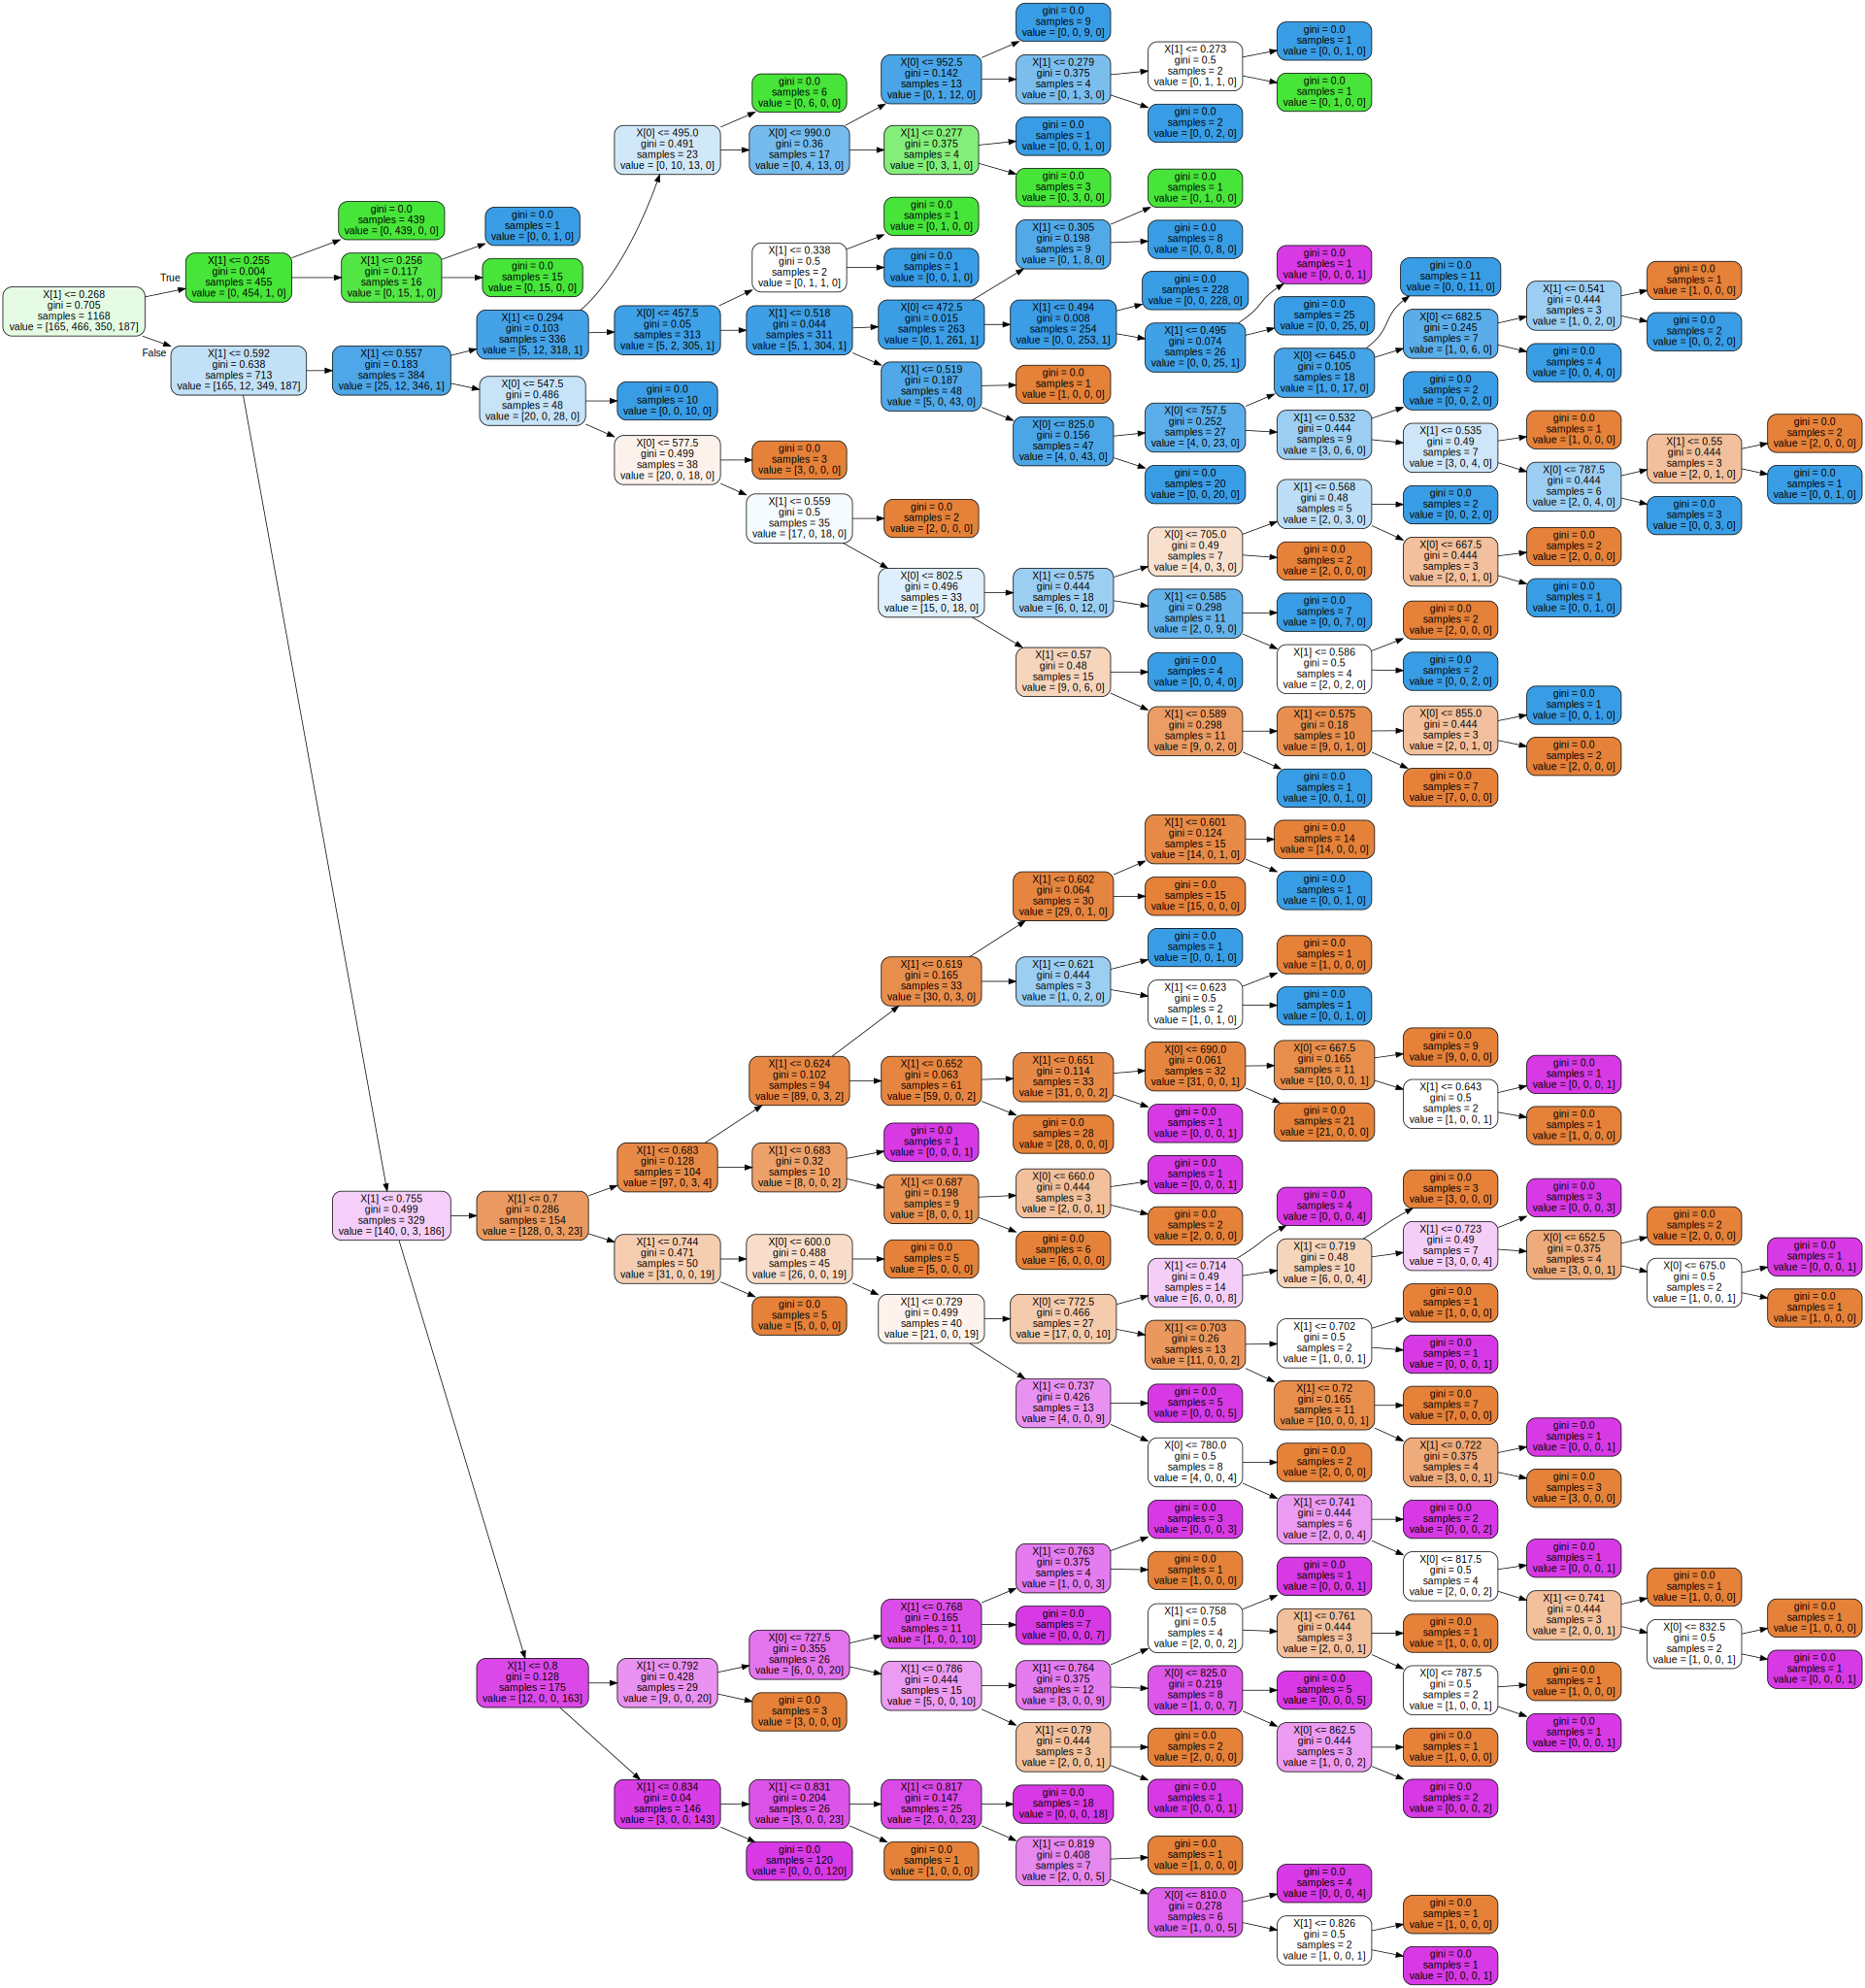

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(dtree,
                           out_file=None, 
                           filled=True,
                           rounded=True,  
                           rotate=True)  

display(graphviz.Source(dot_data))

In [ ]:
!pip install dtreeviz

In [ ]:
from dtreeviz.trees import dtreeviz
viz = dtreeviz(tree_model=dtree,
               x_data=X,
               y_data=y,
               target_name = 'Power_Class',
               feature_names=np.array(feature_names),
               class_names=class_names.tolist(),
               orientation ='LR',
               scale=2.0)              
display(viz)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [ ]:
viz = dtreeviz(tree_model=dtree,
               x_data=X,
               y_data=y,
               target_name=target_name,
               feature_names=np.array(feature_names),
               class_names=class_names.tolist(),
               orientation ='LR',
               X=X_test[0],
               scale=2.0)              
display(viz)

In [ ]:
from dtreeviz.trees import explain_prediction_path

In [ ]:
print(explain_prediction_path(tree_model=dtree,
                              x=X_test[0],
                              feature_names=np.array(feature_names),
                              explanation_type="plain_english"))

0.74 <= IRRADIATION  < 0.75



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


AxesSubplot(0.125,0.125;0.775x0.755)


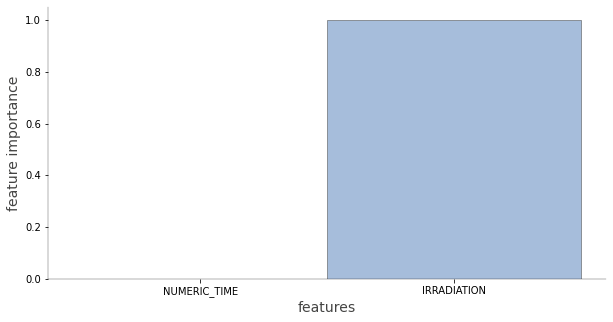

In [ ]:
print(explain_prediction_path(tree_model=dtree,
                              x=X_test[0],
                              feature_names=np.array(feature_names),
                              explanation_type="sklearn_default"))

4

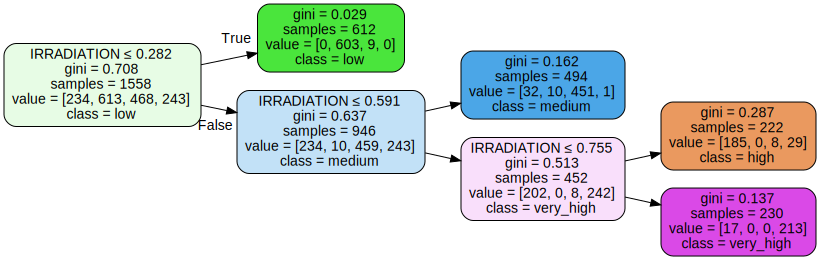

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



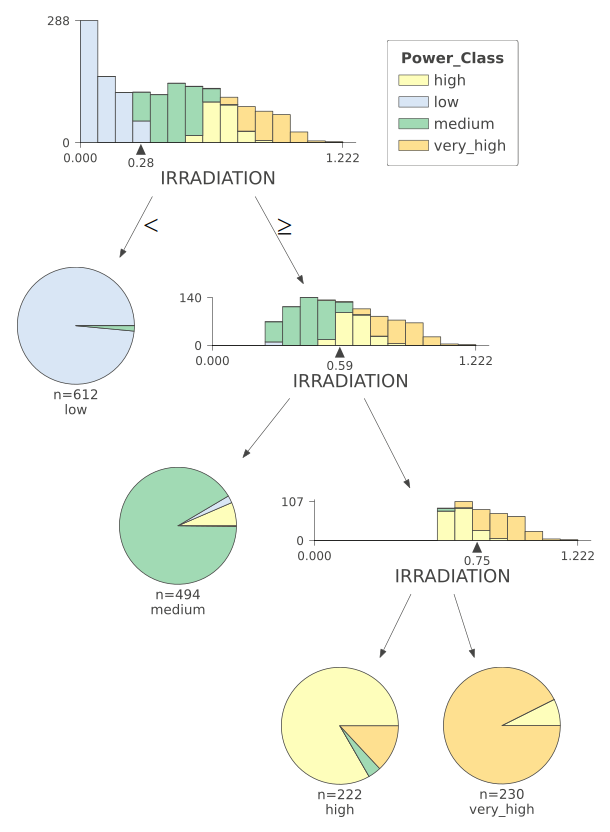

In [ ]:
#@title Interactive Visualizer: How is the tree built? { run: "auto" }

slider = 4 #@param {type:"slider", min:2, max:15, step:1}
display(slider)

dtree = DecisionTreeClassifier(max_leaf_nodes=slider)
dtree.fit(X, y)

dot_data = export_graphviz(dtree,
                           out_file=None, 
                           class_names=class_names.tolist(),
                           feature_names=feature_names,  
                           filled=True,
                           rounded=True,  
                           special_characters=True,
                           rotate=True)  

graph = graphviz.Source(dot_data)  
display(graph)

viz = dtreeviz(tree_model=dtree,
               x_data=X,
               y_data=y,
               target_name=target_name,
               feature_names=np.array(feature_names),
               class_names=class_names.tolist(),
               scale=2.0)              
display(viz)

In [ ]:
dtree.score(X_test, y_test)

0.8948717948717949

In [ ]:
dtree.get_depth()

13

### Vary the criterion hyperparameter:

Vary the following hyperparameters to build your decision tree classifier and report the evaluation metrics for both your training and testing data.

a.	Create a DT using the criterion parameter “gini” and report the accuracy, precision, recall and F1-score.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='gini')
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# New Section

In [ ]:
yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       466
           2       1.00      1.00      1.00       350
           3       1.00      1.00      1.00       187

    accuracy                           1.00      1168
   macro avg       1.00      1.00      1.00      1168
weighted avg       1.00      1.00      1.00      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        69
           1       0.99      0.97      0.98       147
           2       0.94      0.87      0.90       118
           3       0.79      0.82      0.81        56

    accuracy                           0.89       390
   macro avg       0.85      0.86      0.86       390
weighted avg       0.89      0.89      0.89       390



b.	Create a DT using the criterion parameter “entropy” and report the accuracy, precision, recall and F1-score.

In [ ]:
dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       466
           2       1.00      1.00      1.00       350
           3       1.00      1.00      1.00       187

    accuracy                           1.00      1168
   macro avg       1.00      1.00      1.00      1168
weighted avg       1.00      1.00      1.00      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75        69
           1       0.98      0.98      0.98       147
           2       0.92      0.86      0.89       118
           3       0.82      0.91      0.86        56

    accuracy                           0.89       390
   macro avg       0.87      0.88      0.87       390
weighted avg       0.90      0.89      0.90       390



### Vary the splitter hyperparameter:

a.	Create a DT using the splitter parameter “best” and report the accuracy, precision, recall and F1-score.

In [ ]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       466
           2       1.00      1.00      1.00       350
           3       1.00      1.00      1.00       187

    accuracy                           1.00      1168
   macro avg       1.00      1.00      1.00      1168
weighted avg       1.00      1.00      1.00      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        69
           1       0.99      0.97      0.98       147
           2       0.94      0.87      0.90       118
           3       0.84      0.82      0.83        56

    accuracy                           0.89       390
   macro avg       0.87      0.87      0.87       390
weighted avg       0.90      0.89      0.90       390



b.	Create a DT using the splitter parameter “random” and report the accuracy, precision, recall and F1-score.

In [ ]:
dtree = DecisionTreeClassifier(splitter='random')
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

In [ ]:
yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       466
           2       1.00      1.00      1.00       350
           3       1.00      1.00      1.00       187

    accuracy                           1.00      1168
   macro avg       1.00      1.00      1.00      1168
weighted avg       1.00      1.00      1.00      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        69
           1       0.96      0.96      0.96       147
           2       0.90      0.86      0.88       118
           3       0.76      0.84      0.80        56

    accuracy                           0.87       390
   macro avg       0.84      0.84      0.84       390
weighted avg       0.87      0.87      0.87       390



### Vary the min_samples_split hyperparameter:

a.	Choose value 1 as your min_samples_split and report the accuracy, precision, recall and F1-score.

In [ ]:
#Getting ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1
#1 must be a typo, 2 and 3 we will try
dtree = DecisionTreeClassifier(min_samples_split=2)
dtree.fit(X_train, y_train)

yhat_train = dtree.predict(X_train)
print("Training data:")
print(classification_report(y_train, yhat_train))

yhat_test  = dtree.predict(X_test)
print("Test data:")
print(classification_report(y_test, yhat_test))

Training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       466
           2       1.00      1.00      1.00       350
           3       1.00      1.00      1.00       187

    accuracy                           1.00      1168
   macro avg       1.00      1.00      1.00      1168
weighted avg       1.00      1.00      1.00      1168

Test data:
              precision    recall  f1-score   support

           0       0.71      0.81      0.76        69
           1       0.99      0.97      0.98       147
           2       0.94      0.87      0.90       118
           3       0.82      0.82      0.82        56

    accuracy                           0.89       390
   macro avg       0.86      0.87      0.87       390
weighted avg       0.90      0.89      0.89       390



b.	Choose value 2 as your min_samples_split and report the accuracy, precision, recall and F1-score.

In [ ]:
dtree = DecisionTreeClassifier(min_samples_split=3)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       165
           1       1.00      1.00      1.00       466
           2       1.00      0.99      1.00       350
           3       1.00      0.97      0.98       187

    accuracy                           0.99      1168
   macro avg       0.99      0.99      0.99      1168
weighted avg       0.99      0.99      0.99      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        69
           1       0.99      0.97      0.98       147
           2       0.92      0.88      0.90       118
           3       0.83      0.80      0.82        56

    accuracy                           0.89       390
   macro avg       0.86      0.86      0.86       390
weighted avg       0.89      0.89      0.89       390



### Vary the min_samples_leaf hyperparameter:

a.	Choose value 1 as your min_samples_leaf and report the accuracy, precision, recall and F1-score.

In [ ]:
dtree = DecisionTreeClassifier(min_samples_leaf=1)
dtree.fit(X_train, y_train)

yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       466
           2       1.00      1.00      1.00       350
           3       1.00      1.00      1.00       187

    accuracy                           1.00      1168
   macro avg       1.00      1.00      1.00      1168
weighted avg       1.00      1.00      1.00      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        69
           1       0.99      0.97      0.98       147
           2       0.91      0.89      0.90       118
           3       0.79      0.82      0.81        56

    accuracy                           0.88       390
   macro avg       0.85      0.86      0.85       390
weighted avg       0.89      0.88      0.89       390



b.	Choose value 2 as your min_samples_leaf and report the accuracy, precision, recall and F1-score.

In [ ]:
dtree = DecisionTreeClassifier(min_samples_leaf=2)
dtree.fit(X_train, y_train)

yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       165
           1       0.99      1.00      0.99       466
           2       0.99      0.97      0.98       350
           3       0.99      0.91      0.95       187

    accuracy                           0.97      1168
   macro avg       0.96      0.97      0.96      1168
weighted avg       0.98      0.97      0.97      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.71      0.86      0.78        69
           1       0.99      0.98      0.98       147
           2       0.94      0.86      0.90       118
           3       0.88      0.82      0.85        56

    accuracy                           0.90       390
   macro avg       0.88      0.88      0.88       390
weighted avg       0.91      0.90      0.90       390



### Vary the max_depth hyperparameter:

a.	Assign a limiting depth, e.g. 4, for our hyperparameter and report the accuracy, precision, recall and F1-score.

In [ ]:
dtree = DecisionTreeClassifier(max_depth=4)
dtree.fit(X_train, y_train)

yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))


Training data:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       165
           1       1.00      0.97      0.99       466
           2       0.95      0.94      0.94       350
           3       0.93      0.87      0.90       187

    accuracy                           0.94      1168
   macro avg       0.91      0.92      0.92      1168
weighted avg       0.94      0.94      0.94      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.74      0.88      0.81        69
           1       1.00      0.95      0.97       147
           2       0.90      0.87      0.89       118
           3       0.91      0.89      0.90        56

    accuracy                           0.91       390
   macro avg       0.89      0.90      0.89       390
weighted avg       0.91      0.91      0.91       390



b.	Assign a 2nd limiting depth, e.g. 8, for our hyperparameter and report the accuracy, precision, recall and F1-score.

In [ ]:
dtree = DecisionTreeClassifier(max_depth=8)
dtree.fit(X_train, y_train)

yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))


Training data:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       165
           1       1.00      1.00      1.00       466
           2       0.98      0.98      0.98       350
           3       0.96      0.95      0.95       187

    accuracy                           0.97      1168
   macro avg       0.96      0.96      0.96      1168
weighted avg       0.97      0.97      0.97      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        69
           1       0.99      0.97      0.98       147
           2       0.93      0.87      0.90       118
           3       0.84      0.84      0.84        56

    accuracy                           0.89       390
   macro avg       0.87      0.87      0.87       390
weighted avg       0.90      0.89      0.90       390



In [ ]:
dtree.get_depth()

8

### Hyperparameter Overview:

Provide a 2-3 paragraph summary of the results of your hyperparameter exploration. How did your QuAM improve or depreciate with these variations?

Note: It will be tempting to use something like GridSearch, but this automated approach will make it more di	cult to understand how these variations alter your tree, so we recommend varying them manually.

In summary, unless we limited the algorithm by giving a threshold on some parameter, it will always overfit the trainign data. We get 100% fit on the training data, but accuracy on the test data is 88-89% at best. This was expected due to the greedy nature of DTs. However, imposing criteria such as min_sample_leaf and max_depth can make for less variance, though we must then be carful about bias. Basically making max_depth too small, or min_sample_leaf and min_sample_split too big will cause bias.

Entropy was a bit better than gini, but by at most 1%: but this is not meaningful, they are both overfitting data.
splitter = random gives around 3% better accuracy than splitter = best: but this is not meaningful, they are both overfitting data.
min_samples_split=2 is the default and resulted in overfittig. min_samples_split=3 was going in the right direction but it still overfit. (same goes for min_samples_leaf = 1 as default and min_samples_leaf = 2 as departure from greedy approach). Max depth of 8 vs 4 showed very good progress towards lowring variance, but there is still variance with 4 (variance is much larger for 8).

It is obvious that the default values are not going to work properly. Changing parameters such as max_depth, min_samples_leaf, and min_samples_split is very important to adjust the balance between bias and variance.

## Final Decision Tree  & Evaluation

###1. Which feature was used for the first split?


**For the first split DT QuAM used Irradiation less than or equil 0.268**
X[1] <= 0.268
gini = 0.705
samples = 1168
value = [165, 466, 350, 187]

In [ ]:
#Let's come up with a GOOD tree: not biased and not a lot of variance:
dtree = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=4)
dtree.fit(X_train, y_train)

yhat_train = dtree.predict(X_train)
print("Training data:")
print(classification_report(y_train, yhat_train))

yhat_test  = dtree.predict(X_test)
print("Test data:")
print(classification_report(y_test, yhat_test))

Training data:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       165
           1       1.00      0.97      0.99       466
           2       0.90      0.99      0.94       350
           3       0.93      0.87      0.90       187

    accuracy                           0.93      1168
   macro avg       0.92      0.90      0.91      1168
weighted avg       0.93      0.93      0.93      1168

Test data:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        69
           1       1.00      0.95      0.97       147
           2       0.88      0.96      0.91       118
           3       0.91      0.89      0.90        56

    accuracy                           0.92       390
   macro avg       0.91      0.90      0.90       390
weighted avg       0.92      0.92      0.92       390



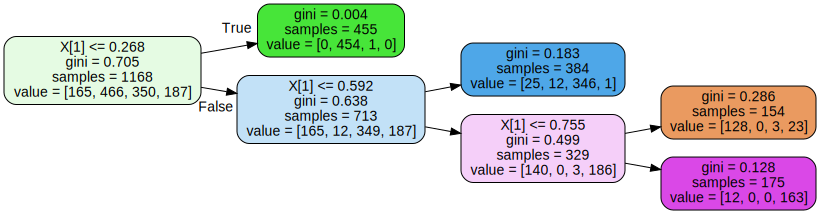

In [ ]:
dot_data = export_graphviz(dtree,
                           out_file=None, 
                           filled=True,
                           rounded=True,  
                           rotate=True)  

display(graphviz.Source(dot_data))

###2. How many leaves are in the optimal classifier/QuAM?


 4 leaf nodes

### Confusion matrix

3. Produce a confusion_matrix and describe your QuAM’s accuracy in terms of the number of true and false positives and negatives.

Training data:


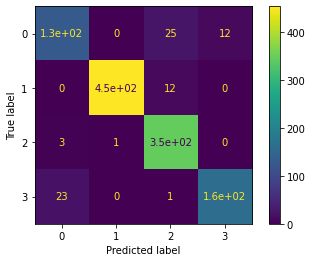

In [ ]:
print("Training data:")
plot_confusion_matrix(dtree, X_train, y_train)

Test data:


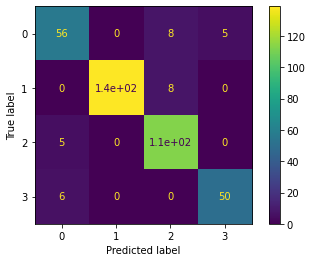

In [ ]:
print("Test data:")
plot_confusion_matrix(dtree, X_test, y_test)

### Accuracy score

4. Using scikit-learn’s classification_report method, generate the accuracy, precision, recall, and f1-score for your model and describe your QuAM’s accuracy.

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix

yhat_train = dtree.predict(X_train)

print("Training data:")
print(classification_report(y_train, yhat_train))

Training data:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       165
           1       1.00      0.97      0.99       466
           2       0.90      0.99      0.94       350
           3       0.93      0.87      0.90       187

    accuracy                           0.93      1168
   macro avg       0.92      0.90      0.91      1168
weighted avg       0.93      0.93      0.93      1168



In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        69
           1       1.00      0.95      0.97       147
           2       0.88      0.96      0.91       118
           3       0.91      0.89      0.90        56

    accuracy                           0.92       390
   macro avg       0.91      0.90      0.90       390
weighted avg       0.92      0.92      0.92       390



In [ ]:
dtree.score(X_test, y_test) 

0.9179487179487179

## Visualize the structure of your final QuAM:

5. Plot your tree. [Hint: using scikit-learn’s tree.plot_tree]

[Text(148.8, 195.696, 'X[1] <= 0.268\ngini = 0.705\nsamples = 1168\nvalue = [165, 466, 350, 187]'),
 Text(111.60000000000001, 152.208, 'gini = 0.004\nsamples = 455\nvalue = [0, 454, 1, 0]'),
 Text(186.0, 152.208, 'X[1] <= 0.592\ngini = 0.638\nsamples = 713\nvalue = [165, 12, 349, 187]'),
 Text(111.60000000000001, 108.72, 'X[1] <= 0.557\ngini = 0.183\nsamples = 384\nvalue = [25, 12, 346, 1]'),
 Text(74.4, 65.232, 'X[1] <= 0.294\ngini = 0.103\nsamples = 336\nvalue = [5, 12, 318, 1]'),
 Text(37.2, 21.744, 'gini = 0.491\nsamples = 23\nvalue = [0, 10, 13, 0]'),
 Text(111.60000000000001, 21.744, 'gini = 0.05\nsamples = 313\nvalue = [5, 2, 305, 1]'),
 Text(148.8, 65.232, 'gini = 0.486\nsamples = 48\nvalue = [20, 0, 28, 0]'),
 Text(260.40000000000003, 108.72, 'X[1] <= 0.755\ngini = 0.499\nsamples = 329\nvalue = [140, 0, 3, 186]'),
 Text(223.20000000000002, 65.232, 'gini = 0.286\nsamples = 154\nvalue = [128, 0, 3, 23]'),
 Text(297.6, 65.232, 'gini = 0.128\nsamples = 175\nvalue = [12, 0, 0, 163]

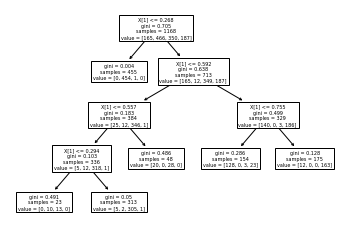

In [ ]:
from sklearn import tree
dtree = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=6)
dtree.fit(X_train, y_train)
tree.plot_tree(dtree)

6. Plot the decision surface of your tree using paired features. [See the following for help implementing:
https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-exa mples-tree-plot-iris-dtc-py ]


In [ ]:
dtree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

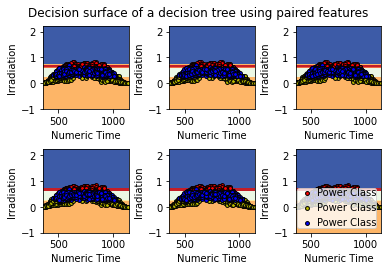

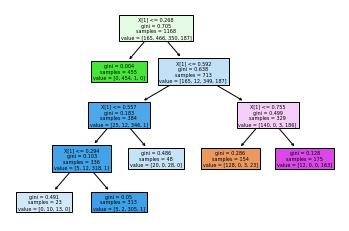

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02


for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    
    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dtree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel('Numeric Time')      
    plt.ylabel('Irradiation')     

    # IS. using these proper labels returns out of range error?
    #plt.xlabel(df_train.columns[pair[0]])
    #plt.ylabel(df_train.columns[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label='Power Class',     #label=iris.target_names[i], 
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

plt.figure()
dtree = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=6).fit(X_train, y_train)
plot_tree(dtree, filled=True)
plt.show()

## Decision tree path:

7. Provide a description of the potential path along your tree that a given new data point might take and provide its final result. The idea being that we want to know what decisions would be made along the way for that data point to end up at a particular label.

# QuAM Accuracy

## Perform a comparison of our Decision Tree QuAM vs kNN QuAM: 

provide a comparison table of accuracy for your various DT QuAMS and your kNN QuAMs. This will be a tool for comparison for you as a technician, but it will also serve as a communication tool to summarize to stakeholders what you tried, what worked best, and why.

-- Our kNN QuAM was trained using the Ambient Temperature whereas for the Decision Tree QuAM we found a much higher correlation of Power Production with the Irradiation feauture. So here, to be able to draw a comparisson to the kNN QuAM, we will also train a parallel Decision Tree model using the Ambient Temperature. 

The main reason for using an Ambient Temperature when we started the project was the wide availability of wheather forecast that could be used for future predictions. However, since the correlation of solar energy production to temperatures are quite low (in 60% range) vs very good correlation to irradiation (in 90% range) we decided to look if we could find the irradiation forecasts out there and apparently there are companies like solcast.com that provide such forecast. Furthermore, in real life it's possible to also build another QuAM that would use the Date/Time in combination with the longitute/latitude and sunny/cloudy features forecasts to come up with our own irradiation forecast that we could feed later into the current QuAM as an input.

###**kNN (with Temperature input) Accuracy score:**



original Accuracy:            0.3814102564102564 <br>
original Precision:           0.14547378369493755<br>
original F1 score:            0.21061633648640607<br>
original Recall score:        0.3814102564102564<br>
normalized Accuracy:          0.375<br>
normalized Precision:         0.140625<br>
normalized F1 score:          0.20454545454545453<br>
normalized Recall score:      0.375<br>
standardized Accuracy:        0.40064102564102566<br>
standardized Precision:       0.16051323142669296<br>
standardized F1 score:        0.22919967141935105<br>
standardized Recall score:    0.40064102564102566<br>


###**DT (with Temperature input) Accuracy score:**

In [ ]:
from sklearn.model_selection import train_test_split

dft_train, dft_test = train_test_split(df_temperature, random_state=0)

Xt_train = dft_train.iloc[:, :-1].values #all but last column
yt_train = dft_train.iloc[:, -1].values  #last column

Xt_test = dft_test.iloc[:, :-1].values
yt_test = dft_test.iloc[:, -1].values

Xt = df.iloc[:, :-1].values
yt = df.iloc[:, -1].values

[Text(167.4, 195.696, 'X[0] <= 997.5\ngini = 0.705\nsamples = 1168\nvalue = [165, 466, 350, 187]'),
 Text(125.55000000000001, 152.208, 'X[1] <= 24.22\ngini = 0.729\nsamples = 940\nvalue = [165, 245, 343, 187]'),
 Text(83.7, 108.72, 'gini = 0.17\nsamples = 192\nvalue = [0, 174, 18, 0]'),
 Text(167.4, 108.72, 'X[1] <= 28.589\ngini = 0.691\nsamples = 748\nvalue = [165, 71, 325, 187]'),
 Text(83.7, 65.232, 'X[0] <= 922.5\ngini = 0.615\nsamples = 375\nvalue = [73, 55, 211, 36]'),
 Text(41.85, 21.744, 'gini = 0.596\nsamples = 330\nvalue = [73, 30, 191, 36]'),
 Text(125.55000000000001, 21.744, 'gini = 0.494\nsamples = 45\nvalue = [0, 25, 20, 0]'),
 Text(251.10000000000002, 65.232, 'X[0] <= 877.5\ngini = 0.68\nsamples = 373\nvalue = [92, 16, 114, 151]'),
 Text(209.25, 21.744, 'gini = 0.597\nsamples = 265\nvalue = [70, 1, 49, 145]'),
 Text(292.95, 21.744, 'gini = 0.574\nsamples = 108\nvalue = [22, 15, 65, 6]'),
 Text(209.25, 152.208, 'gini = 0.06\nsamples = 228\nvalue = [0, 221, 7, 0]')]

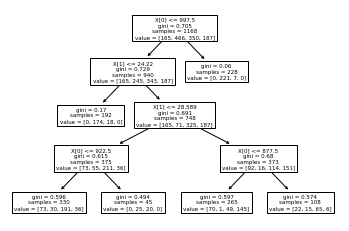

In [ ]:
from sklearn import tree
dtreeT = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=6)
dtreeT.fit(Xt_train, yt_train)
tree.plot_tree(dtreeT)

In [ ]:
dtreeT.score(Xt_test, yt_test)

0.6487179487179487

In [ ]:
yhatT_test  = dtreeT.predict(Xt_test)

print("Test data:")
print(classification_report(yt_test, yhatT_test))

Test data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.90      0.90      0.90       147
           2       0.52      0.69      0.59       118
           3       0.45      0.71      0.56        56

    accuracy                           0.65       390
   macro avg       0.47      0.57      0.51       390
weighted avg       0.56      0.65      0.60       390



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



###**DT (with Irraduation input) Accuracy score:**

In [ ]:
dtree.score(X_test, y_test)

0.9179487179487179

In [ ]:
yhat_test  = dtree.predict(X_test)

print("Test data:")
print(classification_report(y_test, yhat_test))

Test data:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        69
           1       1.00      0.95      0.97       147
           2       0.88      0.96      0.91       118
           3       0.91      0.89      0.90        56

    accuracy                           0.92       390
   macro avg       0.91      0.90      0.90       390
weighted avg       0.92      0.92      0.92       390



### Random Forest vs DT (using Irradiation input)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier()
rforest.fit(X_train, y_train)

yhat_train_rforest = rforest.predict(X_train)
yhat_train_dtree = dtree.predict(X_train)

print("Random forest on training data:")
print(classification_report(y_train, yhat_train_rforest))
print()
print("Decision tree on training data:")
print(classification_report(y_train, yhat_train_dtree))
yhat_test_rforest  = rforest.predict(X_test)
yhat_test_dtree  = dtree.predict(X_test)

print("Random forest on test data:")
print(classification_report(y_test, yhat_test_rforest))
print()
print("Decision tree on test data:")
print(classification_report(y_test, yhat_test_dtree))

Random forest on training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00       466
           2       1.00      1.00      1.00       350
           3       1.00      1.00      1.00       187

    accuracy                           1.00      1168
   macro avg       1.00      1.00      1.00      1168
weighted avg       1.00      1.00      1.00      1168


Decision tree on training data:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       165
           1       1.00      0.97      0.99       466
           2       0.90      0.99      0.94       350
           3       0.93      0.87      0.90       187

    accuracy                           0.93      1168
   macro avg       0.92      0.90      0.91      1168
weighted avg       0.93      0.93      0.93      1168

Random forest on test data:
              precision    recall  f1

# Business Evaluation

# New Section

One of the key objectives of this course is to learn how to implement ML algorithms to tackle business problems and objectives. Please provide us with a complete scenario of how the results of your decision tree classifier might be used.
Note: you’ve previously considered some of these questions, the intent with reconsidering them is to iterate on our problem after obtaining results from our QuAM.


1.	What might be the motivation for a decision tree classifier?

Becasue fo the greedy nature of decision trees (DTs), they make a great candidate data that is by nature highly accurate/distinct with little noise. So data for which overfitting is very unlikely to be a big issue.

DTs do not require a lot of data preparation, e.g., normalization or scaling otherwise.

DTs are immune to corrupting data.? 

DTs are easy to read and interpret for a non-expert, so a very good option to explain technical data to non-technical people, e.g., stakeholders.

Also, it is important to note that the label must have discrete values. So for a problem in real world with conyinuous labels, DTs can offer a good approximation/rough tool.

Creating/training a deision tree can easily get very time and resource intensive due to the greedy nature of the algorithm. It is thus suitable for cases where there is a defined training set available that does not change continuously and thus does not require constant re-trianing of the model. This is particulary important because the structure of a decision tree is very sensitive to change in data, and the previous DT is not necessarily a good strating point for the updated one, so the whole training may have to be repeated. 

2.	What is the “action” that should be taken given the results of this prediction?

Estimate the yearly total solar generation based on historical average temperatures.This would be useful for individual consumers (residential solar) or businesses that have solar to estimate their cost savings and electrical purchasing costs on an annual basis. 

It is vital for the grid operator and electrical governing body (ie AESO, AER) to estimate the solar generation onto the grid for planning purposes (offset generation when solar generation declines at night, maintenance planning, upgrade planning). The governing body needs this info to forecast supply needs from other fuels ie) whether to approve a Natural Gas power plant

IS. If solar energy stored in generators before being transmitted into the grid (to optimize the transmission and distribution cost), then one of the actions would include the streamlining of the generator capacity with the amount of energy generated. Given the energy company should be constantly monitoring the grid prices, this would also allow selling our energy into the grid when prices are more favorable (better grid management).


3.	Who is the best immediate person(s) to make use of the results of your prediction?

Power plant/Energy company
Transmission/distribution companies
Electrical governing body (ie AESO, AER)

4.	What is the potential payoff of this prediction for an organization? (e.g. costs or efficiency).
Helps with prediction and thus allows with cost 

The accuracy of forecasts is very important as it determines the entire budget of the energy producing company, including the trading volumes and prices. Since energy prices are highly volatile and depend on many factors, including grid load and consumption and will change depending on the time in the day, accurate predictions are key for success that can save a company not only operational costs but also prevent trading and transmission/distribution losses (these are determined based on one month forecast data). So timewise this is an ongoing process, but cost wise overall costs also should include opportunity costs  and losses directly tied to the accuracy of the forecast data used and human error - both can greatly benefit from using machine learning algorithms. 

5.	Do your QuAMs results change your problem? If so, how and why?  If not, please explain.

Initially, we were planning on relying on temperature for forecast, but realized through using different inputs for the DT model, irradiation is a better indicator as it has better corrolation with power generation. We also searched and reallized that irradition forecast is available, and can thus be used as an input.

Linear Regression


In [ ]:
from sklearn.linear_model import LinearRegression

# Learning Curve

In [ ]:
from sklearn.model_selection import train_test_split
#Split Dataset into training and test data
from sklearn.model_selection import train_test_split# first lets just quickly make a DC power which is categorical to keep in line with Decision tree
df = df_p1.copy()
# make categorical labels to use the Decision tree
target = df["DC_POWER_PER_INVERTER"]

label_categories=["low", "medium", "high", "very_high", "unknown"]
label_type = pd.CategoricalDtype(categories=label_categories)

df["POWER_CLASS"] = "unknown"
df["POWER_CLASS"] = df["POWER_CLASS"].astype(label_type)

# Classifiers based on visual inspection of plot DC Power vs Ambient Temp
low_value_rows = (target < 4000)
medium_value_rows = (target >= 4000) & (target < 8000)
high_value_rows = (target >= 8000) & (target < 10000)
very_high_value_rows = (target >= 10000)

df.loc[low_value_rows, "POWER_CLASS"] = "low"
df.loc[medium_value_rows, "POWER_CLASS"] = "medium"
df.loc[high_value_rows, "POWER_CLASS"] = "high"
df.loc[very_high_value_rows, "POWER_CLASS"] = "very_high"


#Convert Date_Time into numeric values
#Transform POWER_CLASS to number labels
from sklearn.preprocessing import LabelEncoder
le_power_class = LabelEncoder()
df['POWER_CLASS_L'] = le_power_class.fit_transform(df['POWER_CLASS'])
df.drop('POWER_CLASS',axis=1, inplace=True)
df
df['NUMERIC_TIME'] = 0.0
df['NUMERIC_TIME'] =  (df['DATE_TIME'] - pd.to_datetime(df['DATE_TIME']).dt.floor('d')).astype('timedelta64[m]').astype(float)
df = df[['NUMERIC_TIME'] + df.columns[:-1].tolist()].copy()
df.drop('DATE_TIME',axis=1, inplace=True)
df.drop('MODULE_TEMPERATURE',axis=1, inplace=True)
df.drop('DC_POWER_PER_INVERTER',axis=1, inplace=True)
df_temperature = df.drop('IRRADIATION',axis=1)
#df.drop('AMBIENT_TEMPERATURE',axis=1, inplace=True)

#These variables are to be used for the plot labels later
inputs = df.drop('POWER_CLASS_L',axis='columns')
feature_names = inputs.columns.tolist()
target = df['POWER_CLASS_L']
target_name = 'Power_Class'

df.name = "Original Data"

display(df)

NUMERIC_TIME  AMBIENT_TEMPERATURE  IRRADIATION  POWER_CLASS_L
0             360.0            24.088446     0.005887              1
21            375.0            24.011635     0.022282              1
42            390.0            23.976731     0.049410              1
64            405.0            24.218990     0.095394              1
86            420.0            24.537398     0.141940              1
...             ...                  ...          ...            ...
33874        1080.0            24.130349     0.041940              1
33896        1095.0            24.038157     0.023446              1
33918        1110.0            23.840239     0.007007              1
33940        1125.0            23.583049     0.000039              1
33962        1140.0            23.474888     0.000000              1

[1558 rows x 4 columns]

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier

feat_1 = "NUMERIC_TIME"
feat_2 = "AMBIENT_TEMPERATURE"
feat_3 = "IRRADIATION"

for scorer in ['accuracy']:#, 'precision_weighted','f1_weighted','recall_weighted']:
  #df = df_normalized.copy()
  #df.name = df_standardized.name
  #split the dataset into a training set and a testing set
  df_train, df_test = train_test_split(df, test_size=0.2)
  X_train = df_train[[feat_1,feat_2, feat_3]]
  X_test = df_test[[feat_1,feat_2, feat_3]]

  #Make last column into feature into the output i.e. Label (y)
  y_train = df_train['POWER_CLASS_L']
  y_test = df_test['POWER_CLASS_L']

  data_sizes, training_scores, validation_scores = \
  learning_curve(DecisionTreeClassifier(max_depth = 6), X_train, \
                 y_train, cv=5, scoring=scorer, \
                 train_sizes=np.linspace(0.01, 1.0, 100))
  training_mean = training_scores.mean(axis=1) 
  training_standard_deviation = training_scores.std(axis=1) 
  validation_mean = validation_scores.mean(axis=1) 
  validation_standard_deviation = validation_scores.std(axis=1)
  fig = go.Figure()

  fig.add_trace(go.Scatter(x=data_sizes,  y=training_mean,mode='lines',name='Training',line=dict(color='red')))
  fig.add_trace(go.Scatter(x=data_sizes,y=training_mean - training_standard_deviation,mode='lines',name='Training lower bound',line=dict(width=0, color='red'),showlegend=False))
  fig.add_trace(go.Scatter(x=data_sizes,y=training_mean + training_standard_deviation,mode='lines',name='Training upper bound',line=dict(width=0, color='red'),fill='tonexty',fillcolor='rgba(255, 0, 0, 0.3)',showlegend=False))

  fig.add_trace(go.Scatter(x=data_sizes, y=validation_mean,mode='lines',name='Validation',line=dict(color='blue')))
  fig.add_trace(go.Scatter(x=data_sizes, y=validation_mean - validation_standard_deviation,mode='lines',name='Validation lower bound',line=dict(width=0, color='blue'),showlegend=False))
  fig.add_trace(go.Scatter(x=data_sizes, y=validation_mean + validation_standard_deviation,mode='lines',name='Validation upper bound',line=dict(width=0, color='blue'),fill='tonexty',fillcolor='rgba(0, 0, 255, 0.3)',showlegend=False))

  fig.update_xaxes(range=[0, 1000])
  fig.update_yaxes(range=[0.4, 1])

  fig.update_layout(title="Learning curve for "+df.name+" dateset",xaxis_title='Dataset size',yaxis_title=scorer, height=300, width=600,margin=dict(l=0, r=0, t=100, b=0))
  fig.show()


In [ ]:
#Use Grid Search Cross Validation to find the best model for the standardized set
from sklearn.model_selection import GridSearchCV
#for scorer in ['accuracy', 'precision_weighted','f1_weighted','recall_weighted']:
for scorer in ['accuracy']:
  print("Score Method: "+scorer)
  for weight in ['uniform']:#,'distance']:
      print("   Weight: "+weight)    
      #separated data for 5 kFold cross validations
      X = df[["NUMERIC_TIME","AMBIENT_TEMPERATURE","IRRADIATION"]]
      y = df["POWER_CLASS_L"]
      #create new a knn model
      DTC = DecisionTreeClassifier()
      #create a dictionary of all values we want to test for n_neighbors
      param_grid = {'max_depth': np.arange(1, 30)}
      #use gridsearch to test all values for n_neighbors
      dt_gscv = GridSearchCV(DTC, param_grid, cv=5, scoring=scorer)
      #fit model to data
      dt_gscv.fit(X, y)
      #check top performing n_neighbors value
      print("         Best max_depth: "+str(dt_gscv.best_params_))
      #check mean score for the top performing value of n_neighbors
      print("         Best max_depth: "+str(dt_gscv.best_score_))


Score Method: accuracy
   Weight: uniform


KeyError: ignored

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

result_columns = ['max_depth','Train_Accuracy','Test_Accuracy','cv_Mean_Accuracy','cv_Std_Accuracy']
df_results = pd.DataFrame(columns=result_columns)
weight_methods = ['uniform', 'distance']

#Select two features as feat_1 and feat_2
feat_1 = "NUMERIC_TIME"
feat_2 = "AMBIENT_TEMPERATURE"
feat_3 = "IRRADIATION"
#for df_c in [df_original, df_normalized, df_standardized]:
#  df = df_c.copy()
#  df.name = df_c.name
#split the dataset into a training set and a testing set
df_train, df_test = train_test_split(df, test_size=0.2)
X = df[[feat_1,feat_2,feat_3]]
y = df['POWER_CLASS_L']
X_train = df_train[[feat_1,feat_2,feat_3]]
X_test = df_test[[feat_1,feat_2, feat_3]]  #Make last column into feature into the output i.e. Label (y)
y_train = df_train['POWER_CLASS_L']
y_test = df_test['POWER_CLASS_L']  
for weight_method in weight_methods:
  for n in range(1,20):
    #print("kNN Neighbors: "+str(n))      #make predictions
    dt = DecisionTreeClassifier(max_depth=n)
    dt.fit(X_train, y_train)
    yhat_train = dt.predict(X_train)  
    yhat_test = dt.predict(X_test)  
    cv_acc = cross_val_score(dt, X, y, cv=5)
    cv_mean_acc = np.mean(cv_acc)
    cv_std_acc = np.std(cv_acc)      #get metrics
    train_acc = accuracy_score(y_train, yhat_train)
    test_acc = accuracy_score(y_test, yhat_test)      
    temp = pd.DataFrame([[n, train_acc, test_acc,cv_mean_acc, cv_std_acc ]], columns = result_columns)
    #temp = pd.DataFrame([[df.name,weight_method, n, train_acc, test_acc,cv_mean_acc, cv_std_acc ]], columns = result_columns)
    df_results = df_results.append(temp)


display(df_results)

max_depth  Train_Accuracy  Test_Accuracy  cv_Mean_Accuracy  cv_Std_Accuracy
0         1        0.669342       0.727564          0.676505         0.010128
0         2        0.829053       0.807692          0.826057         0.011396
0         3        0.938202       0.913462          0.924252         0.010554
0         4        0.941413       0.910256          0.919117         0.011075
0         5        0.944623       0.903846          0.924256         0.010699
0         6        0.954254       0.913462          0.920406         0.008757
0         7        0.963884       0.910256          0.910135         0.012056
0         8        0.973515       0.916667          0.906287         0.010647
0         9        0.978331       0.907051          0.901146         0.015291
0        10        0.984751       0.903846          0.899219         0.016113
0        11        0.991974       0.897436          0.898582         0.007282
0        12        0.994382       0.900641          0.903714         0.012888
0        13        0.995185       0.907051          0.896659         0.010450
0        14        0.995987       0.907051          0.899219         0.012360
0        15        0.997592       0.907051          0.898586         0.007221
0        16        0.999197       0.907051          0.897945         0.008708
0        17        0.999197       0.881410          0.896653         0.013124
0        18        1.000000       0.900641          0.901783         0.013500
0        19        1.000000       0.910256          0.900503         0.015108
0         1        0.669342       0.727564          0.676505         0.010128
0         2        0.829053       0.807692          0.826057         0.011396
0         3        0.938202       0.913462          0.924252         0.010554
0         4        0.941413       0.910256          0.919117         0.011075
0         5        0.944623       0.907051          0.924256         0.010699
0         6        0.954254       0.913462          0.919765         0.008889
0         7        0.963884       0.910256          0.910770         0.015447
0         8        0.973515       0.913462          0.905005         0.011055
0         9        0.979936       0.907051          0.899866         0.009218
0        10        0.984751       0.900641          0.901785         0.011329
0        11        0.991974       0.897436          0.903075         0.008991
0        12        0.994382       0.907051          0.897302         0.012012
0        13        0.995185       0.903846          0.896653         0.008817
0        14        0.995185       0.900641          0.898586         0.008765
0        15        0.997592       0.903846          0.903714         0.011719
0        16        0.999197       0.900641          0.901801         0.008928
0        17        0.999197       0.884615          0.897941         0.013398
0        18        1.000000       0.903846          0.899217         0.015871
0        19        1.000000       0.907051          0.898582         0.011803